In [35]:
import os
import pandas as pd
from copy import deepcopy
from collections import defaultdict
import geopandas as gp
from matplotlib import pyplot as plt

current_dir = globals()['_dh'][0]
parent_dir = os.path.dirname(current_dir)
path_to_repo = parent_dir

# PAM - Getting Started

**Pandemic Activity Modelling/Modifying**

This notebook is a quick spin through PAM. Intended to provide a technical overview and inspire further research and development.

### Load Data

Here we load simple travel diary data of London commuters. This is a very simple 0.1% sample of data about work and education commutes from the 2011 census. Because we're sharing this date - we've aggregated locations to borough level and randomized personal attributes - so don't get too excited about the results.

The data is available in `pam/example_data`.

In [36]:
trips = pd.read_csv(os.path.join(path_to_repo, 'example_data/example_travel_diaries.csv'))
attributes = pd.read_csv(os.path.join(path_to_repo, 'example_data/example_attributes.csv'))
attributes.set_index('pid', inplace=True)

In [37]:
trips.head(10)

,uid,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet,freq
0,0,census_0,census_0,0,Harrow,Harrow,Camden,work,pt,444,473,1000
1,1,census_0,census_0,1,Harrow,Camden,Harrow,work,pt,890,919,1000
2,2,census_1,census_1,0,Greenwich,Greenwich,Tower Hamlets,work,pt,507,528,1000
3,3,census_1,census_1,1,Greenwich,Tower Hamlets,Greenwich,work,pt,1065,1086,1000
4,4,census_2,census_2,0,Croydon,Croydon,Croydon,work,pt,422,425,1000
5,5,census_2,census_2,1,Croydon,Croydon,Croydon,work,pt,917,920,1000
6,6,census_3,census_3,0,Haringey,Haringey,Redbridge,work,pt,428,447,1000
7,7,census_3,census_3,1,Haringey,Redbridge,Haringey,work,pt,1007,1026,1000
8,8,census_4,census_4,0,Hounslow,Hounslow,"Westminster,City of London",work,car,483,516,1000
9,9,census_4,census_4,1,Hounslow,"Westminster,City of London",Hounslow,work,car,1017,1050,1000


### Build Activity Plans

First we convert the travel diary data to Activity Plans:

In [38]:
from pam import read
population = read.load_travel_diary(trips, attributes)

Using tour based purpose parser using (recommended)
Using freq of 'None' for all persons.


Let's check out an example Activity Plan and Attributes:

In [39]:
household = population.households['census_120']
person = household.people['census_120']
person.print()

Person: census_120
{'gender': 'other', 'job': 'work', 'occ': 'white', 'inc': 'low'}
0:	Activity(0 act:home, location:Bexley, time:00:00:00 --> 09:47:00, duration:9:47:00)
1:	Leg(0 mode:pt, area:Bexley --> Greenwich, time:09:47:00 --> 10:04:00, duration:0:17:00)
2:	Activity(1 act:work, location:Greenwich, time:10:04:00 --> 17:12:00, duration:7:08:00)
3:	Leg(1 mode:pt, area:Greenwich --> Bexley, time:17:12:00 --> 17:29:00, duration:0:17:00)
4:	Activity(2 act:home, location:Bexley, time:17:29:00 --> 00:00:00, duration:6:31:00)


In [40]:
person.attributes

{'gender': 'other', 'job': 'work', 'occ': 'white', 'inc': 'low'}

Before we do any activity modification - we create a simple function to extract some example statistics. We include this as a simple demo, but would love to add more.

Note that activity plans allow us to consider detailed **joint** segmentations, such as socio-economic, spatial, temporal, modal, activity sequence and so on.

In [41]:
def print_simple_stats(population):
    """
    Print some simple population statistics.
    """
    time_at_home = 0
    travel_time = 0 
    low_income_central_trips = 0
    high_income_central_trips = 0
    
    for hid, hh in population.households.items():
        for pid, person in hh.people.items():
            freq = person.freq
            
            for p in person.plan:
                if p.act == 'travel':
                    if p.duration.seconds:
                        duration = p.duration.seconds * freq / 3600
                        travel_time += duration
                    
                    if p.end_location.area == "Westminster,City of London":
                        if person.attributes['inc'] == "low":
                            low_income_central_trips += freq
                            
                        elif person.attributes['inc'] == "high":
                            high_income_central_trips += freq
                    
                else:  # activity
                    if p.act == 'home':
                        if p.duration.seconds:
                            duration = p.duration.seconds * freq / 3600
                            time_at_home += duration
                        
    print(f"Population total time at home: {time_at_home/1000000:.2f} million hours")
    print(f"Population total travel time: {travel_time/1000000:.2f} million hours")
    print(f"Low income trips to Central London: {low_income_central_trips} trips")
    print(f"High income trips to Central London: {high_income_central_trips} trips")
                        

In [42]:
print_simple_stats(population)

Population total time at home: 43.74 million hours
Population total travel time: 1.58 million hours
Low income trips to Central London: 229000.0 trips
High income trips to Central London: 246000.0 trips


In [43]:
def plot_simple_stats(population):
    """
    Print some simple population statistics.
    """
    geoms = gp.read_file(os.path.join(path_to_repo, "example_data/geometry.geojson"))

    departures = defaultdict(int)
    arrivals = defaultdict(int)
    
    for hid, hh in population.households.items():
        for pid, person in hh.people.items():
            freq = person.freq
            
            for p in person.plan:
                if p.act == 'travel':
                    departures[p.start_location.area] += freq
                    arrivals[p.end_location.area] += freq
    geoms['departures'] = geoms.NAME.map(departures)
    geoms['arrivals'] = geoms.NAME.map(arrivals)
        
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    for i, name in enumerate(['departures', 'arrivals']):
        
        ax[i].title.set_text(name)
        geoms.plot(name, ax=ax[i])
        ax[i].axis('off')


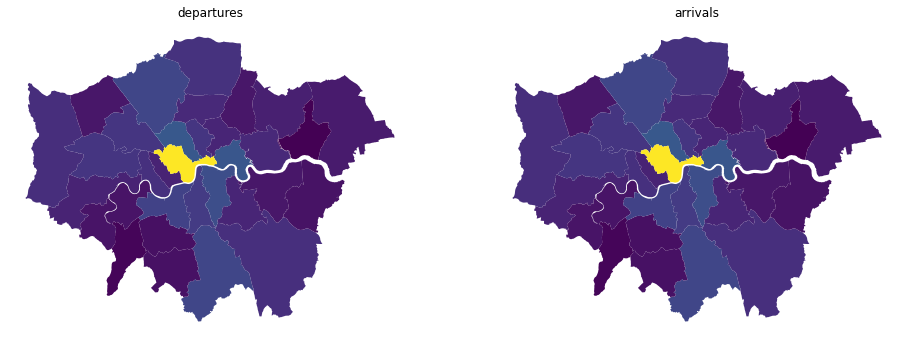

In [44]:
plot_simple_stats(population)

### Scenarios

Our 2011 baseline London population of commuters seems sensible, they spend about 50 million hours at home and 1.6 million hours travelling.

But what if we want to try and build some more up to date scenarios?

We consider 3 policies:

1. A household will be quarantined with p=0.025
2. A person will be staying at home (self isolating) with p=0.1
3. Education activities will be removed and plans adjusted with p=0.9

In [45]:
from pam import policy
policy1 = policy.HouseholdQuarantined(probability=0.025)
policy2 = policy.PersonStayAtHome(probability=0.1)
policy3 = policy.RemovePersonActivities(['education'], probability=0.9)
policy4 = policy.RemoveHouseholdActivities(['education', 'work'], probability=0.9)

We then build 3 example population scenarios:

1. policy 1 + policy 2
2. policy 1 + policy 2 + policy 3
3. policy 1 + policy 2 + policy 4

In [46]:
from pam.policy import apply_policies

In [47]:
population1 = apply_policies(population, [policy1, policy2])
population2 = apply_policies(population, [policy1, policy2, policy3])
population3 = apply_policies(population, [policy1, policy2, policy4])

### Review

So this has been a pretty quick and dirty demo. But we can still take a look at our new population scenario stats below. Obviously we'd like to add some more analytics... some viz... some validation... then output new travel plans and OD matrices for use in other models.

Population total time at home: 38.04 million hours
Population total travel time: 1.38 million hours
Low income trips to Central London: 196000.0 trips
High income trips to Central London: 213000.0 trips


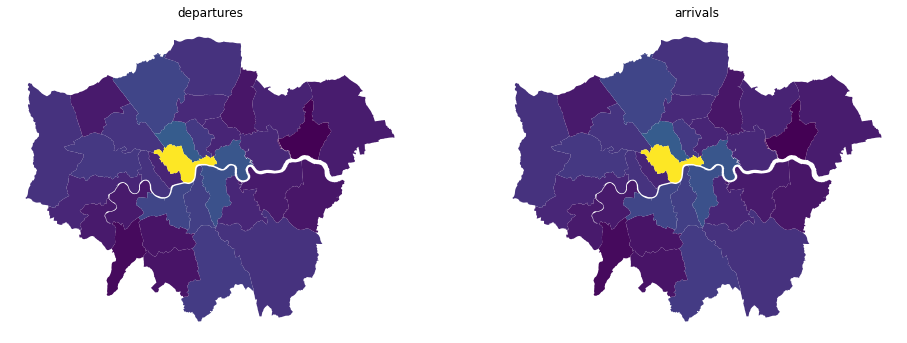

In [48]:
print_simple_stats(population1)
plot_simple_stats(population1)

Population total time at home: 31.65 million hours
Population total travel time: 1.15 million hours
Low income trips to Central London: 173000.0 trips
High income trips to Central London: 174000.0 trips


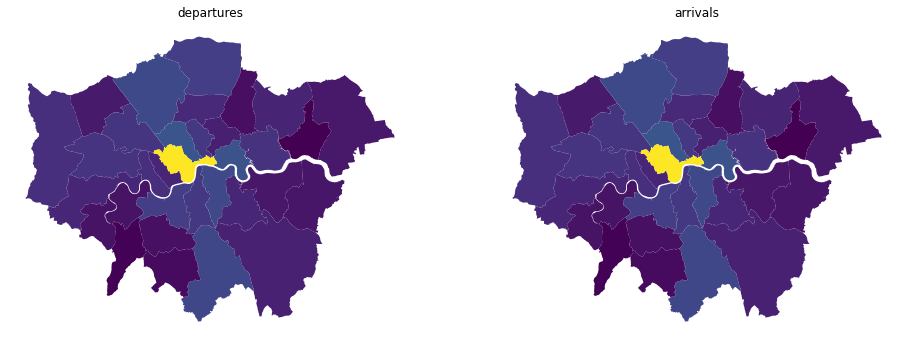

In [49]:
print_simple_stats(population2)
plot_simple_stats(population2)

Population total time at home: 3.52 million hours
Population total travel time: 0.14 million hours
Low income trips to Central London: 20000.0 trips
High income trips to Central London: 20000.0 trips


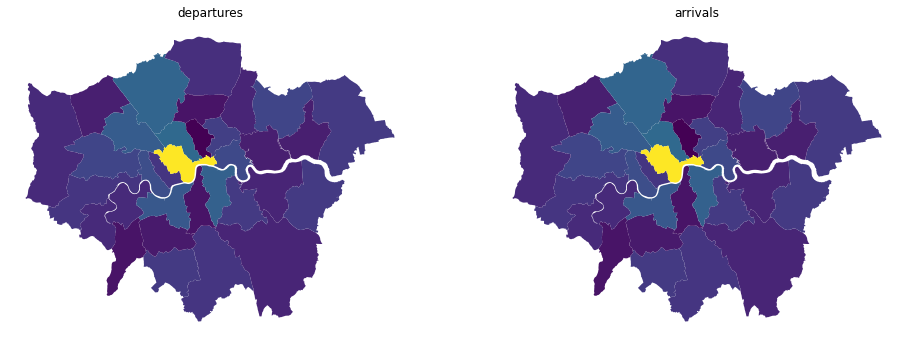

In [50]:
print_simple_stats(population3)
plot_simple_stats(population3)

### Footnote - Build Your Own Person

In [51]:
from pam.core import Population, Household, Person
from pam.activity import Plan, Activity, Leg
from pam.utils import minutes_to_datetime

In [52]:
person = Person(1)
person.add(
    Activity(
        seq=1,
        act='home',
        area='a',
        start_time=minutes_to_datetime(0),
        end_time=minutes_to_datetime(60)
    )
)
person.add(
    Leg(
        seq=1,
        mode='car',
        start_area='a',
        end_area='b',
        start_time=minutes_to_datetime(60),
        end_time=minutes_to_datetime(90)
    )
)
person.add(
    Activity(
        seq=2,
        act='education',
        area='b',
        start_time=minutes_to_datetime(90),
        end_time=minutes_to_datetime(120)
    )
)
person.add(
    Leg(
        seq=2,
        mode='car',
        start_area='b',
        end_area='a',
        start_time=minutes_to_datetime(120),
        end_time=minutes_to_datetime(180)
    )
)
person.add(
    Activity(
        seq=3,
        act='home',
        area='a',
        start_time=minutes_to_datetime(180),
        end_time=minutes_to_datetime(24 * 60 - 1)
    )
)

In [53]:
person.print()

Person: 1
{}
0:	Activity(1 act:home, location:a, time:00:00:00 --> 01:00:00, duration:1:00:00)
1:	Leg(1 mode:car, area:a --> b, time:01:00:00 --> 01:30:00, duration:0:30:00)
2:	Activity(2 act:education, location:b, time:01:30:00 --> 02:00:00, duration:0:30:00)
3:	Leg(2 mode:car, area:b --> a, time:02:00:00 --> 03:00:00, duration:1:00:00)
4:	Activity(3 act:home, location:a, time:03:00:00 --> 23:59:00, duration:20:59:00)


In [54]:
a, b = person.remove_activity(2)

In [55]:
person.print()

Person: 1
{}
0:	Activity(1 act:home, location:a, time:00:00:00 --> 01:00:00, duration:1:00:00)
1:	Leg(1 mode:car, area:a --> b, time:01:00:00 --> 01:30:00, duration:0:30:00)
2:	Leg(2 mode:car, area:b --> a, time:02:00:00 --> 03:00:00, duration:1:00:00)
3:	Activity(3 act:home, location:a, time:03:00:00 --> 23:59:00, duration:20:59:00)


In [56]:
person.fill_plan(a,b)

True

In [57]:
person.print()

Person: 1
{}
0:	Activity(1 act:home, location:a, time:00:00:00 --> 23:59:00, duration:23:59:00)
